In [332]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [333]:
full_employee_data: pd.DataFrame = pd.DataFrame()

is_ethic = False

In [334]:
def load_employee_data():
    global full_employee_data

    general_data = pd.read_csv('datasets/general_data.csv')
    employee_survey_data = pd.read_csv('datasets/employee_survey_data.csv')
    manager_survey_data = pd.read_csv('datasets/manager_survey_data.csv')

    full_employee_data = general_data.merge(employee_survey_data, on='EmployeeID')
    full_employee_data = full_employee_data.merge(manager_survey_data, on='EmployeeID')

In [335]:
load_employee_data()

In [336]:
def create_working_time_columns():
    """
        Process in_time.csv and out_time.csv data to create working time columns in the general_data dataframe
    """
    global full_employee_data
    in_time: pd.DataFrame = pd.read_csv('datasets/in_time.csv').astype('datetime64[s]')
    out_time = pd.read_csv('datasets/out_time.csv').astype('datetime64[s]')

    average: pd.DataFrame = (out_time - in_time)

    # Convert to hours
    average = average.loc[:, :] / np.timedelta64(1, 'h')

    working_time_df = pd.DataFrame()

    # Create a column EmployeeID
    working_time_df['EmployeeID'] = in_time.iloc[:, 0]
    working_time_df['EmployeeID'] = working_time_df['EmployeeID'].astype('int64')

    # Create a column min and max
    working_time_df['AverageArrivalTime'] = in_time.iloc[:, 1:].mean(axis=1)
    working_time_df['AverageDepartureTime'] = out_time.iloc[:, 1:].max(axis=1)

    # Create a column average
    working_time_df['AverageWorkingTime'] = average.mean(axis=1).round(2)

    # Merge the working time data with the general data
    full_employee_data = full_employee_data.merge(working_time_df, on='EmployeeID')

In [337]:
create_working_time_columns()

In [338]:
def find_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def cap_outliers_in_dataframe(df):
    df = df.copy()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):  # Check if the column contains numeric data
            outliers = find_outliers_iqr(df[column])

            # Cap the outliers by replacing them with lower/upper bounds
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df[column] = np.where(outliers, np.clip(df[column], lower_bound, upper_bound), df[column])

    return df

In [339]:
full_employee_data = cap_outliers_in_dataframe(full_employee_data)

In [340]:
full_employee_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0.0,0.0,3.0,4.0,2.0,3,3,2015-07-01 20:02:09,2015-12-31 17:17:33,7.34
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1.0,4.0,3.0,2.0,4.0,2,3,2015-07-02 21:34:52,2015-12-31 17:40:58,7.69
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0.0,3.0,2.0,2.0,1.0,3,3,2015-07-02 07:38:41,2015-12-31 17:15:50,6.98
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7.0,5.0,4.0,4.0,3.0,2,3,2015-07-02 14:53:02,2015-12-31 17:09:14,7.16
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0.0,4.0,4.0,1.0,3.0,3,3,2015-07-03 11:04:33,2015-12-31 17:42:14,7.97


In [341]:
full_employee_data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.0,4410,4410,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,63620.857143,2.677067,15.209524,8.0,...,1.922789,4.107483,2.723603,2.728246,2.761436,2.729932,3.0,2015-07-02 13:33:37,2015-12-31 16:26:48,7.667669
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.0,2015-06-25 23:23:58,2015-12-28 16:23:16,5.920000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,2015-07-01 14:22:27,2015-12-31 16:31:33,6.642500
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,2015-07-02 13:04:22,2015-12-31 17:19:53,7.380000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.0,2015-07-03 13:10:49,2015-12-31 18:18:57,8.330000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,165835.000000,8.500000,25.000000,8.0,...,7.500000,14.500000,4.000000,4.000000,4.000000,4.000000,3.0,2015-07-08 15:12:23,2015-12-31 21:56:13,10.861250
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,43528.133258,2.455392,3.659108,0.0,...,2.477660,3.516689,1.092756,1.101253,0.706245,0.711400,0.0,NaN,NaN,1.333214


In [342]:
# EmployeeCount : All values are 1
# Over18 : All values are 'Y'
# StandardHours : All values are 8
full_employee_data = full_employee_data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

if not is_ethic:
    full_employee_data = full_employee_data.drop(['Age', 'Education', 'Education', 'MaritalStatus'], axis=1)

In [343]:
#Encoding
cat_data = ['Gender', 'Department', 'BusinessTravel', 'EducationField', 'JobRole'] + (['MaritalStatus'] if is_ethic else [])
for i in cat_data:
    vals = pd.get_dummies(full_employee_data[i], sparse=True)
    full_employee_data = pd.concat([full_employee_data, vals], axis=1)
    
full_employee_data['Attrition'] = full_employee_data['Attrition'].map({'Yes': 1, 'No': 0})

In [344]:
full_employee_data = full_employee_data.drop(cat_data, axis=1)

In [345]:
#Imputation

imputer = SimpleImputer(strategy='median')
for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = imputer.fit_transform(full_employee_data[[cat_name]])

print(full_employee_data.isnull().sum())

Attrition                    0
DistanceFromHome             0
EmployeeID                   0
JobLevel                     0
MonthlyIncome                0
NumCompaniesWorked           0
PercentSalaryHike            0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
YearsAtCompany               0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
JobInvolvement               0
PerformanceRating            0
AverageArrivalTime           0
AverageDepartureTime         0
AverageWorkingTime           0
Female                       0
Male                         0
Human Resources              0
Research & Development       0
Sales                        0
Non-Travel                   0
Travel_Frequently            0
Travel_Rarely                0
Human Resources              0
Life Sciences                0
Marketing                    0
Medical 

In [346]:
#Scaling

scaler = MinMaxScaler()
for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = scaler.fit_transform(full_employee_data[[cat_name]])
full_employee_data

,Attrition,DistanceFromHome,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,Technical Degree,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative
0,0.0,0.178571,0.000000,0.00,0.777360,0.117647,0.000000,0.0,0.035088,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.321429,0.000227,0.00,0.204180,0.000000,0.857143,0.4,0.210526,0.625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.571429,0.000454,0.75,1.000000,0.117647,0.285714,1.0,0.175439,0.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.035714,0.000680,0.50,0.469485,0.352941,0.000000,1.0,0.456140,1.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.321429,0.000907,0.00,0.085589,0.470588,0.071429,0.8,0.315789,0.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.0,0.142857,0.999093,0.00,0.322322,0.352941,0.428571,0.4,0.350877,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4406,0.0,0.035714,0.999320,0.00,0.107227,0.235294,0.285714,0.0,0.350877,0.375,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4407,0.0,0.857143,0.999546,0.25,0.172911,0.000000,0.642857,0.0,0.175439,0.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4408,0.0,0.607143,0.999773,0.00,0.089184,0.000000,0.214286,0.4,0.350877,0.375,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


   Attrition  DistanceFromHome  EmployeeID  JobLevel  MonthlyIncome  \
0        0.0          0.178571    0.000000      0.00       0.777360   
1        1.0          0.321429    0.000227      0.00       0.204180   
2        0.0          0.571429    0.000454      0.75       1.000000   
3        0.0          0.035714    0.000680      0.50       0.469485   
4        0.0          0.321429    0.000907      0.00       0.085589   

   NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0            0.117647           0.000000               0.0           0.035088   
1            0.000000           0.857143               0.4           0.210526   
2            0.117647           0.285714               1.0           0.175439   
3            0.352941           0.000000               1.0           0.456140   
4            0.470588           0.071429               0.8           0.315789   

   TrainingTimesLastYear  ...  Technical Degree  Healthcare Representative  \
0       

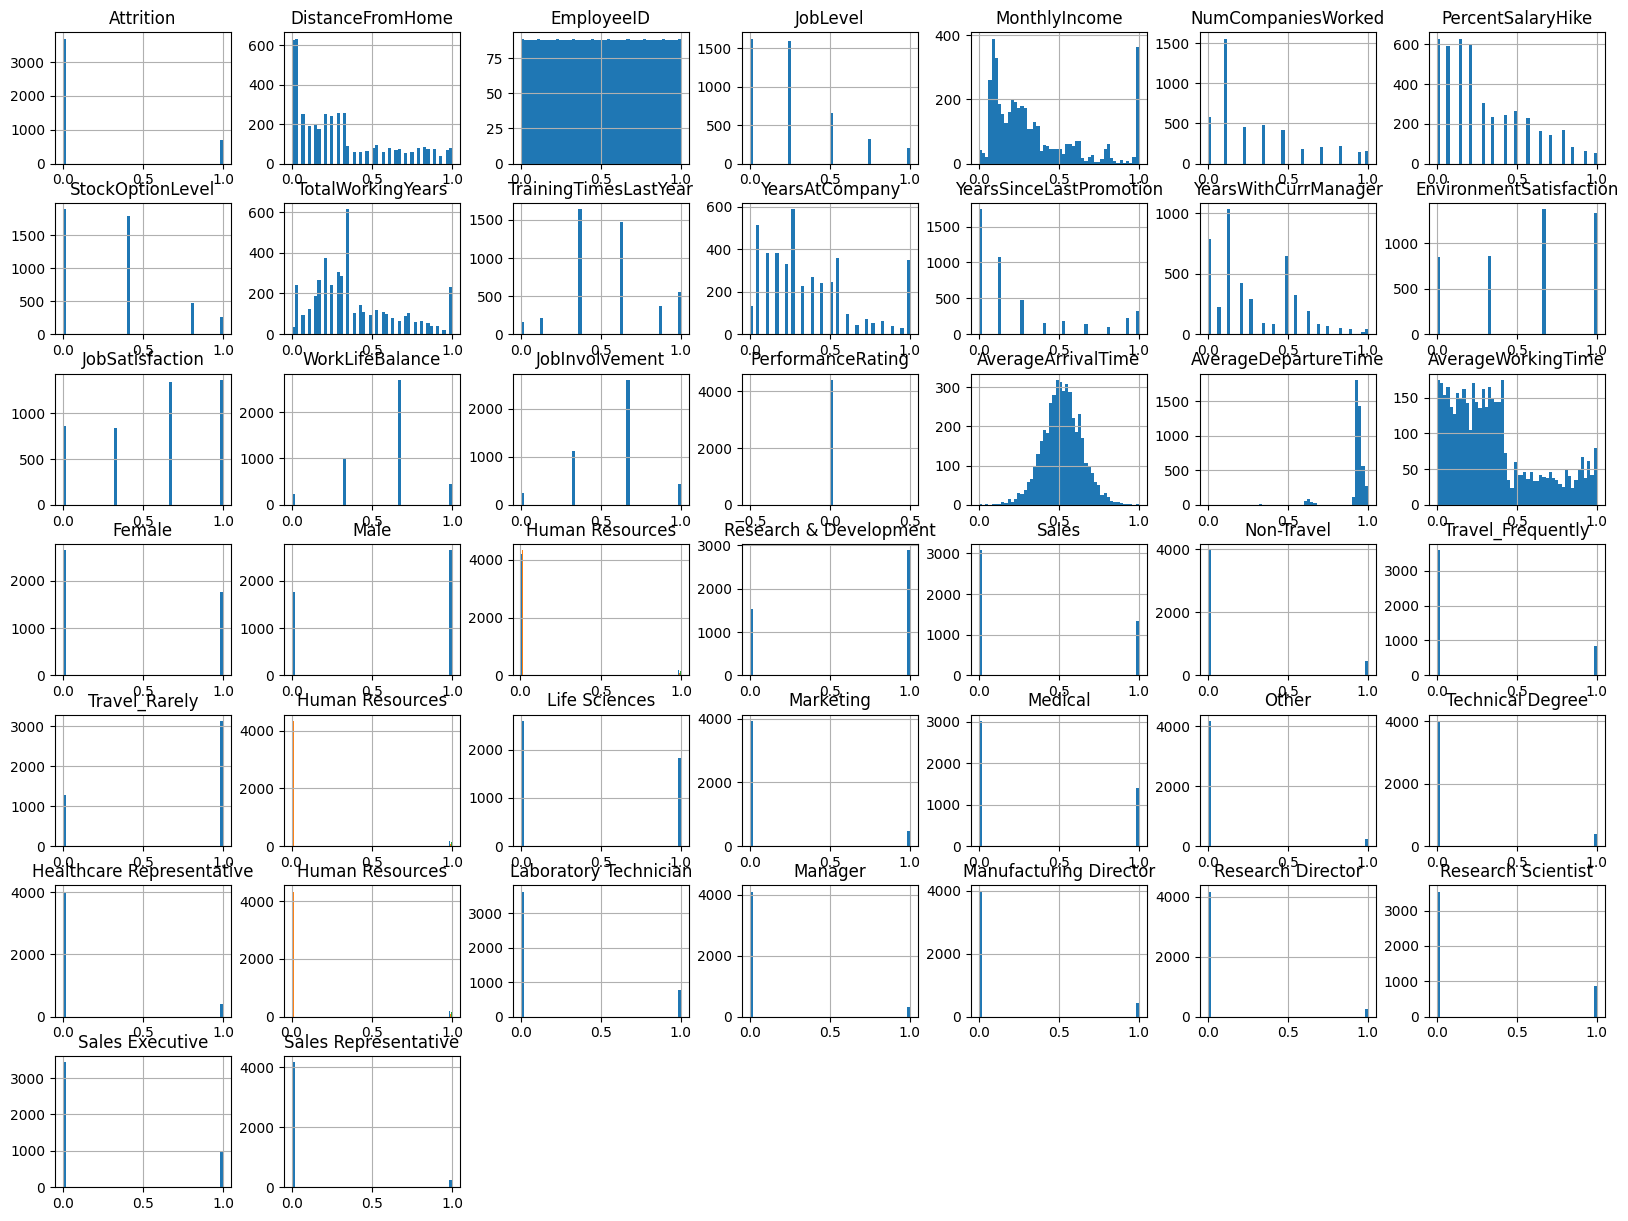

In [347]:
# Display the first 5 rows of the data
print(full_employee_data.head())

# Display the shape of the data
print(full_employee_data.shape)

# Display the columns of the data
print(full_employee_data.columns)

# Display the summary statistics of the data
print(full_employee_data.describe(include='all'))

# Display the missing values in the data
print(full_employee_data.isnull().sum())

# Display the unique values in the data
full_employee_data.hist(bins=50, figsize=(20, 15))
plt.show()

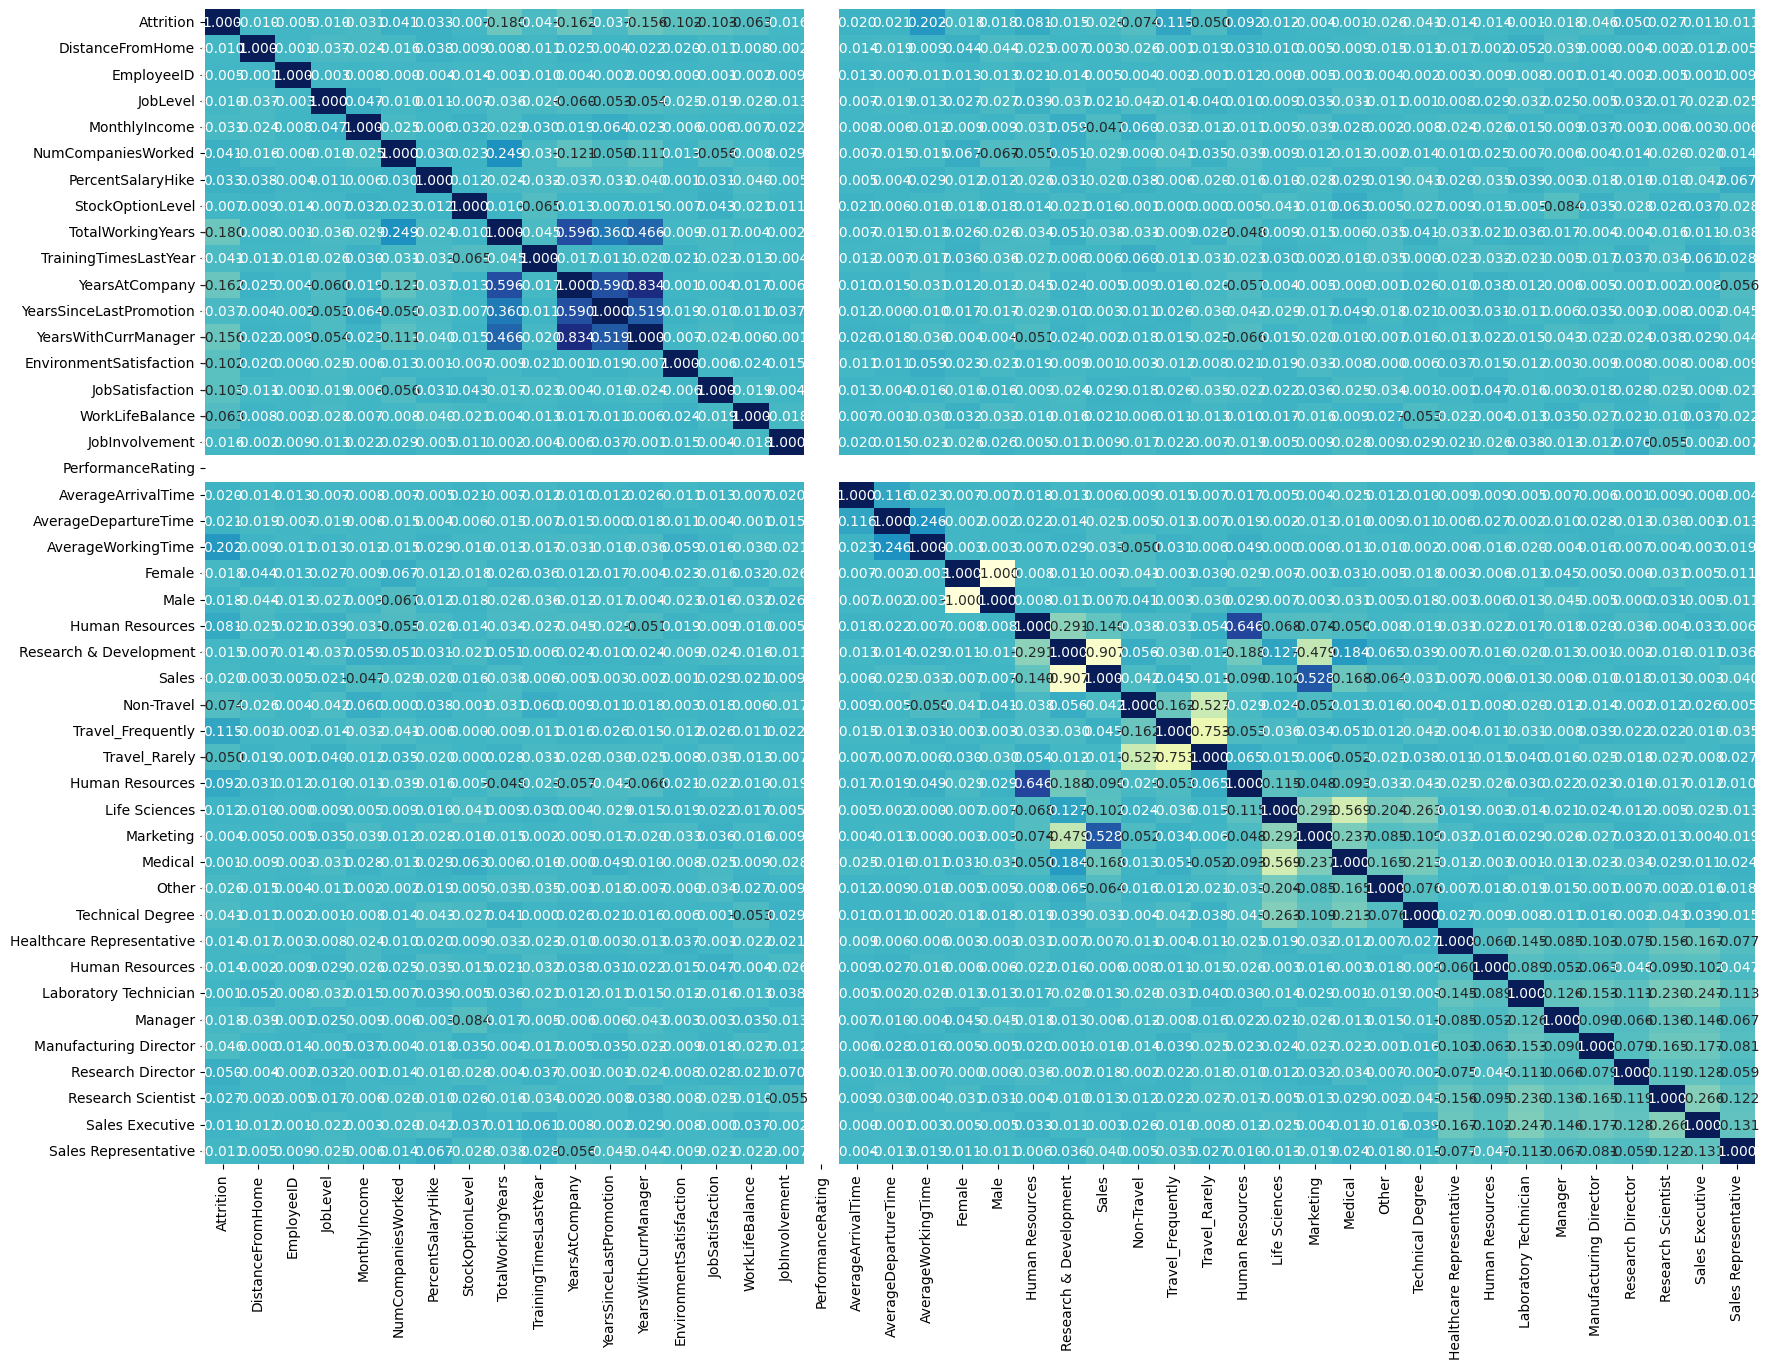

In [348]:

# Display the correlation matrix of the data
corr_matrix = full_employee_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 15), edgecolor='white')
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='YlGnBu', cbar=False)
plt.show()

In [349]:
full_employee_data.to_csv('full_employee_data_cleaned.csv', index=False)